### PD Controller for the Drone Height
Implementation of a Drone Simulator with its controller for the height

![title](pid.jpg)

### Drone Controller
Controller Class for the Drone Dynamical simulation

In [4]:
##################################################################################
# Your goal is to follow the comments and complete the the tasks asked of you.
#
# Good luck designing your proportional derivative controller!
#
##################################################################################

class PD_Controller:
    def __init__(self, kp = 0.0, kd = 0.0, start_time = 0):
        
        # The PD controller can be initalized with a specific kp value
        # and kd value
        self.kp_ = float(kp)
        self.kd_ = float(kd)
        
        # Define last_error_ and set to 0.0
        ########################################
        self.last_error_ = 0.0
        ########################################

        # Store relevant data
        self.last_timestamp_ = 0.0
        self.set_point_ = 0.0
        self.start_time_ = start_time
        self.error_sum_ = 0.0

        # Control effort history
        self.u_p = [0]
        self.u_d = [0]

    def setTarget(self, target):
        self.set_point_ = float(target)

    def setKP(self, kp):
        self.kp_ = float(kp)
        
    def setKD(self, kd):
        # Set the internal kd_ value with the provided variable
        ########################################
        self.kd_ = float(kd)
        
        ########################################

    def update(self, measured_value, timestamp):
        delta_time = timestamp - self.last_timestamp_
        if delta_time == 0:
            # Delta time is zero
            return 0
        
        # Calculate the error 
        error = self.set_point_ - measured_value
        
        # Set the last_timestamp_ 
        self.last_timestamp_ = timestamp

        # Find error_sum_
        self.error_sum_ += error * delta_time
        
        # Calculate the delta_error
        ########################################
        delta_error = error - self.last_error_
        ########################################
        
        # Update the past error with the current error
        ########################################
        self.last_error_ = error
        ########################################

        # Proportional error
        p = self.kp_ * error
       
        # Calculate the derivative error here. Be sure to access the 
        # the internal Kd class variable
        ########################################
        d = self.kd_ *  (delta_error/ delta_time)
        ########################################
        
        # Set the control effort
        # u is the sum of all your errors. In this case it is just 
        # the proportional and derivative error.
        ########################################
        u = p + d
        ########################################
        
        # Here we are storing the control effort history for post control
        # observations. 
        self.u_p.append(p)
        self.u_d.append(d)

        return u

### Drone Dynamics Simulation
Dynamical Equations of a 1D Quadrotor

In [5]:
import numpy as np
import matplotlib.pyplot as plt

##################################################################################
## DO NOT MODIFY ANY PORTION OF THIS FILE
# This file represents the dynamical equations of motion for the 1D quadrotor
##################################################################################

def ydot(y, t, p):
    ''' Returns the state vector at the next time-step

    Parameters:
    ----------
    y(k) = state vector, a length 2 list
      = [altitude, speed]
    t = time, (sec)
    pid = instance of the PIDController class

    Returns
    -------
    y(k+1) = [y[0], y[1]] = y(k) + ydot*dt
    '''

    # Model state
    y0 = y[0] # altitude, (m)
    y1 = y[1] # speed, (m/s)


    # Model parameters
    g = -9.81 # gravity, m/s/s
    m =  1.54 # quadrotor mass, kg
    c =  10.0 # electro-mechanical transmission constant

    # time step, (sec)
    dt = t - p.last_timestamp_
    # Control effort
    u = p.update(y0,t)

    ### State derivatives
    # if altitude = 0
    if (y0 <= 0.):
        # if control input, u <= gravity, vehicle stays at rest on the ground
        # this prevents quadrotor from "falling" through the ground when thrust is
        # too small.
        if u <= np.absolute(g*m/c):
            y0dot = 0.
            y1dot = 0.
        else:  # else if u > gravity and quadrotor accelerates upwards
            y0dot = y1
            y1dot = g + c/m*u - 0.75*y1
    else: # otherwise quadrotor is already in the air
        y0dot = y1
        y1dot = g + c/m*u - 0.75*y1

    y0 += y0dot*dt
    y1 += y1dot*dt
    return [y0, y1]

### Plotting
Plot section for the resulting trajectory and actuation

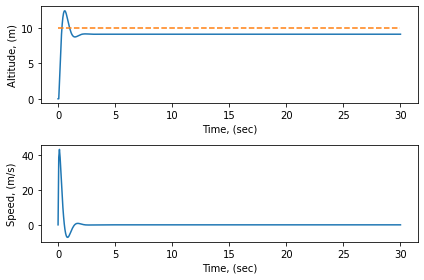

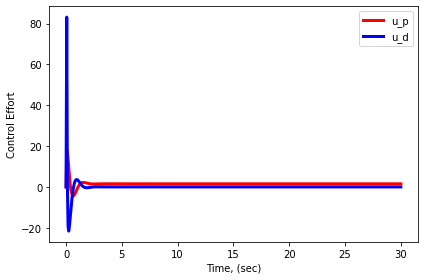

The rise time is 0.361 seconds
The percent overshoot is 24.6%
The steady state offset at 30 seconds is 0.858 meters


In [12]:
import numpy as np
import matplotlib.pyplot as plt

##################################################################################
##################################################################################
# This code is what will be executed and what will produce your results
# For this quiz you need to set kd below to your desired value
# Then modify pd_controller.py to build out your PD controller
kp = 1.76
kd = 0.5
# Note that kd needs to be set to 0.45 in order to pass the project
# You are encouraged to change Kd in order to observe the effects
# What happens when Kd is really small?
# What happens when Kd is really large?
# Do we notice anything relating Kd and the control effort?
# Observe the percent overshoot!
##################################################################################
##################################################################################

# Simulation parameters
N = 500 # number of simultion points
t0 = 0  # starting time, (sec)
tf = 30 # end time, (sec)
time = np.linspace(t0, tf, N)
dt = time[1] - time[0] # delta t, (sec)

##################################################################################
# Core simulation code
# Inital conditions (i.e., initial state vector)
y = [0, 0]
   #y[0] = initial altitude, (m)
   #y[1] = initial speed, (m/s)

# Initialize array to store values
soln = np.zeros((len(time),len(y)))

# Create instance of PI_Controller class
pd = PD_Controller()

# Set the Kp value of the controller
pd.setKP(kp)

# Set the Kd value of the controller
pd.setKD(kd)

# Set altitude target
r = 10 # meters
pd.setTarget(r)

# Simulate quadrotor motion
j = 0 # dummy counter
for t in time:
    # Evaluate state at next time point
    y = ydot(y,t,pd)
    # Store results
    soln[j,:] = y
    j += 1

##################################################################################
# Plot results
SP = np.ones_like(time)*r # altitude set point
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(time, soln[:,0],time,SP,'--')
ax1.set_xlabel('Time, (sec)')
ax1.set_ylabel('Altitude, (m)')

ax2 = fig.add_subplot(212)
ax2.plot(time, soln[:,1])
ax2.set_xlabel('Time, (sec)')
ax2.set_ylabel('Speed, (m/s)')
plt.tight_layout()
plt.show()

fig2 = plt.figure()
ax3 = fig2.add_subplot(111)
ax3.plot(time, pd.u_p, label='u_p', linewidth=3, color = 'red')
ax3.plot(time, pd.u_d, label='u_d', linewidth=3, color = 'blue')
ax3.set_xlabel('Time, (sec)')
ax3.set_ylabel('Control Effort')
h, l = ax3.get_legend_handles_labels()
ax3.legend(h, l)
plt.tight_layout()
plt.show()
##################
y0 = soln[:,0] #altitude
rise_time_index =  np.argmax(y0>r)
RT = time[rise_time_index]
print("The rise time is {0:.3f} seconds".format(RT))

OS = (np.max(y0) - r)/r*100
if OS < 0:
    OS = 0
print("The percent overshoot is {0:.1f}%".format(OS))

print ("The steady state offset at 30 seconds is {0:.3f} meters".format(abs(soln[-1,0]-r)))